In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

In [46]:
df=pd.read_csv("Speed_Dating_Data.csv", encoding = "ISO-8859-1")

# Peut ont predire le succès d'un rdv en fonction de l'importance qu'un individu apporte a differentes qualités (Intelligence, Attirance, sincerité, Humour Ambition, Interet commun)?

Une première idée serait d'essayer de voir si on peut predire la décision finale d'un type (est ce que il/elle veut revoir la personne qu'il a rencontré) en fonction de l'impression qu'a eu le type sur la personne et l'importance qu'il/elle apporte à differents critères.

La décision finale est contenu dans la variable dec (1=yes, 0=no).

L'importance que l'individu apporte aux differents critères sont contenue dans les variables: attr1_1 (Attractive), 
sinc1_1 (Sincere), intel1_1 (Intelligent),fun1_1 (Fun ),amb1_1 (Ambitious), shar1_1 (Shared Interests/Hobbies)  . La question etait la suivante: "You have 100 points to distribute among the following attributes -- give more points to those attributes that are more important in a potential date, and fewer points to those attributes that are less important in a potential date.  Total points must equal 100." (ca c'est pour les vagues de 1 a 5 et de 10 a 21, sinon les gens repondent en donnant une note sur 10)

Les notes attribuées sont contenus dans les variables: attr, sinc, intel, fun, amb, shar.


On fait un nouveau data frame (df2) contenant toutes les variables qui nous interessent, on garde que les individus qui ont repondus a toutes les questions, sur une echelle de 100. list_var contient la liste de toutes les varaibles qui nous interressent.

In [47]:
list_qual=["attr","sinc","intel","fun","amb","shar","dec"]
list_var=[i for i in df.columns if ((any(x in i for x in list_qual)&("1_1" in i))| (i in list_qual))]
df2=df[(df.wave<6)|(df.wave>9)]

In [48]:
df2=pd.concat([df2[[i]] for i in list_var],axis=1).dropna()

La gueule du dataframe:

In [49]:
df2.head()

,attr1_1,sinc1_1,intel1_1,fun1_1,amb1_1,shar1_1,dec,attr,sinc,intel,fun,amb,shar
0,15.0,20.0,20.0,15.0,15.0,15.0,1,6.0,9.0,7.0,7.0,6.0,5.0
1,15.0,20.0,20.0,15.0,15.0,15.0,1,7.0,8.0,7.0,8.0,5.0,6.0
2,15.0,20.0,20.0,15.0,15.0,15.0,1,5.0,8.0,9.0,8.0,5.0,7.0
3,15.0,20.0,20.0,15.0,15.0,15.0,1,7.0,6.0,8.0,7.0,6.0,8.0
4,15.0,20.0,20.0,15.0,15.0,15.0,1,5.0,6.0,7.0,7.0,6.0,6.0


Maintenant il faut verifier que la somme des varialbes vaut bien 100, et supprimer les individus qui savent pas compter. On voit bien ci dessous que yen a , on va dire qu'on tej que 120 148 90 110 et 95

In [50]:
df2["somme"]=df2.attr1_1+ df2.sinc1_1+df2.intel1_1+df2.amb1_1+df2.shar1_1 +df2.fun1_1
df2.somme.unique()
df2=df2[(df2.somme<110)&(df2.somme>95)].drop("somme",1)

# La partie machine learning 1

Dans cette partie on fait juste un arbre de decision sans faire de parameter fitting

In [51]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score

On veut predire la variable dec (Y) en fonctions des autres variables contenu dans notre dataframe.

In [52]:
train=df2.sample(frac=0.8,random_state=200)
test=df2.drop(train.index)

In [53]:
Ytrain=train.dec.values
Ytest=test.dec.values
Xtrain=train.drop("dec",1).values
Xtest=test.drop("dec",1).values

In [54]:
clf1=DecisionTreeClassifier()
clf2=RandomForestClassifier()

In [55]:
clf1.fit(Xtrain,Ytrain)
clf2.fit(Xtrain,Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [56]:
Ypred1=clf1.predict(Xtest)
Ypred2=clf2.predict(Xtest)

Ci dessous la matrice de confusion, qui represente les true positives et true negative en diagonale normale et les false positive et false negative en diagonale inverse.

In [57]:
print(confusion_matrix(Ytest,Ypred1))
print(confusion_matrix(Ytest,Ypred2))

[[484 145]
 [158 320]]
[[551  78]
 [163 315]]


le F1 score qui est pas top (on voit qu'il est meilleur quand on utilise un random forest plutot qu'un seul arbre de decision)

In [58]:
print(f1_score(Ytest,Ypred1),f1_score(Ytest,Ypred2))

0.67868504772 0.723306544202


# La partie parameter fitting

On essaye de voir dans cette partie si en changeant les parametres, on peut obtenir un meilleur score. Faut trouver les meilleurs parametres possible

In [59]:
def split(frac,df):
    train=df.sample(frac=frac,random_state=200)
    test=df.drop(train.index)
    return(train,test)
def XY(train,test):
    Ytrain=train.dec.values
    Ytest=test.dec.values
    Xtrain=train.drop("dec",1).values
    Xtest=test.drop("dec",1).values
    return(Xtrain,Xtest,Ytrain,Ytest)
def n_estimators(n,frac,df):
    clf=RandomForestClassifier(n_estimators=n)
    train,test=split(frac,df)
    clf.fit(XY(train,test)[0], XY(train,test)[2])
    Ypred=clf.predict(XY(train,test)[1])
    return(f1_score(XY(train,test)[3],Ypred ))
    
    
    

In [69]:
l=[]
for i in range (2,100):
    l.append(n_estimators(i,0.8,df2))
    

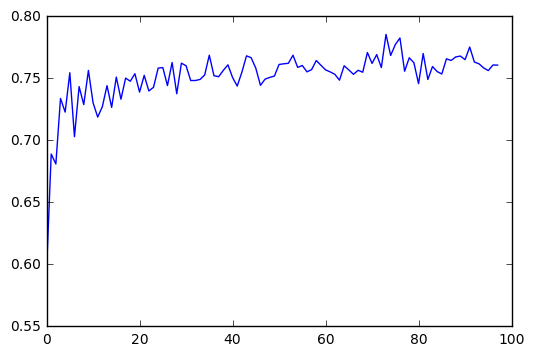

In [70]:
plt.plot(l)